# Senior Isolation Notebook


In [281]:
#importing modules
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


#reading altarum and ipsos csv files, formatting dataframes
altarum_loneliness = pd.read_csv('Data/altarum_loneliness_data.csv')
altarum_visitors = pd.read_csv('Data/altarum_visitors_per_week_data.csv')
ipsos_loneliness = pd.read_csv('Data/ipsos_loneliness_data.csv')

altarum_loneliness = altarum_loneliness.set_index('Unnamed: 0')
altarum_visitors = altarum_visitors.set_index('Unnamed: 0')
ipsos_loneliness = ipsos_loneliness.set_index('Unnamed: 0')


#reading HRS data from .sas7bdat files, generated from original .da files given by HRS using SAS software
hrs_2012_lb = pd.read_sas('Data\h12lb_r.sas7bdat')
hrs_2012_n = pd.read_sas('Data\h12n_r.sas7bdat')
hrs_2012_pr_r = pd.read_sas('Data\h12pr_r.sas7bdat')

#setting basic styles and formatting for plots
%matplotlib inline 
plt.style.use("seaborn")

#ERROR: from pd.read_sas

c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
c:\users\razfyz\vs code projects\senior isolation report\isolation_report_venv\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


HRS: Loneliness as function of age

Altarum Survey: Loneliness increase after restrictions implemented

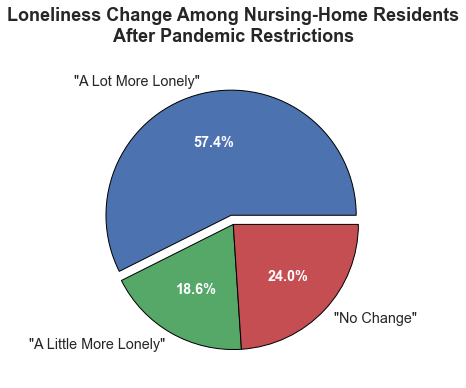

In [282]:
#manipulating dataframe to input into 'plt.pie'
alt_loneliness_series = altarum_loneliness.unstack(1)

#setting labels for each section of the pie chart
labels = ["\"A Lot More Lonely\"", "\"A Little More Lonely\"", "\"No Change\""]

#parameters for explode
explode = [0.075, 0, 0]

#rendering the pie chart with styling
plt.title("Loneliness Change Among Nursing-Home Residents\nAfter Pandemic Restrictions\n", fontsize=18, fontweight='bold')
patches, texts, pcts = plt.pie(alt_loneliness_series, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', explode=explode, textprops={'size': 'x-large'})
plt.setp(pcts, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Altarum Survey: Visitors before and after restrictions implemented

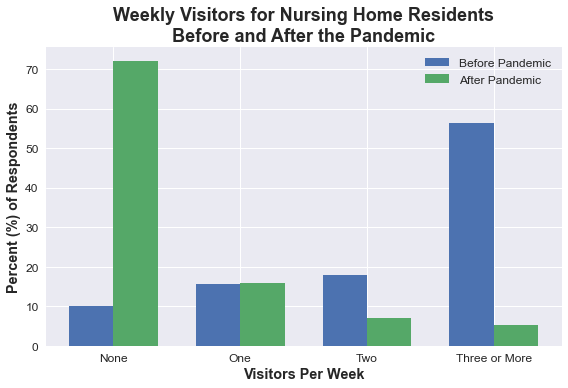

In [283]:
# %matplotlib notebook

#manipulating dataframe to create two series with data for the double bar graph
visitors_pre_rest = altarum_visitors.iloc[0]
visitors_post_rest = altarum_visitors.iloc[1]

#set manual bar width and 'x_indexes' to make offsets possible
x_indexes = np.arange(len(visitors_pre_rest))
width = 0.35

#rendering double bar graph with styling
plt.title("Weekly Visitors for Nursing Home Residents\nBefore and After the Pandemic", 
                            fontsize=18, fontweight='bold')
plt.bar(x_indexes - width/2, visitors_pre_rest, width=width, label='Before Pandemic')
plt.bar(x_indexes + width/2, visitors_post_rest, width=width, label='After Pandemic')

#NOTE: add 'edgecolor='black', linewidth=1' to plt.bar if you want to add borders to each of the bars

plt.xlabel('Visitors Per Week', fontsize='x-large', fontweight='bold')
plt.ylabel('Percent (%) of Respondents', fontsize='x-large', fontweight='bold')
plt.xticks(ticks=x_indexes, labels=['None', 'One', 'Two', 'Three or More'], fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')
plt.tight_layout()
plt.show()

Ipsos Survey: Loneliness among all Americans (and entire world) from COVID (((( **DELETE** ))))

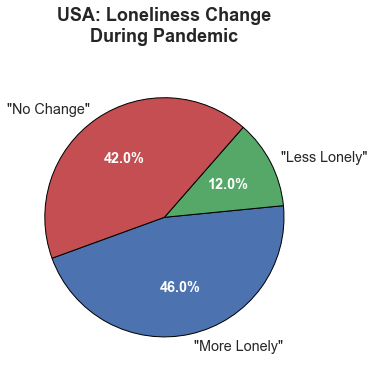

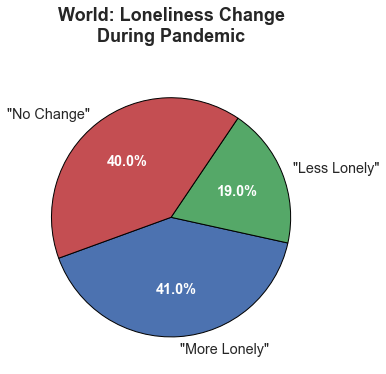

In [284]:
usa_pcts = ipsos_loneliness.iloc[0]
wrld_pcts = ipsos_loneliness.iloc[1]

labels = ["\"More Lonely\"", "\"Less Lonely\"", "\"No Change\""]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

ax1.set_title("USA: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight='bold')
patches, texts, pcts = ax1.pie(usa_pcts, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', textprops={'size': 'x-large'}, startangle=200)
plt.setp(pcts, color='white', fontweight='bold')

ax2.set_title("World: Loneliness Change\nDuring Pandemic\n", fontsize=18, fontweight='bold')
patches, texts, pcts = ax2.pie(wrld_pcts, labels=labels, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, 
                            autopct='%1.1f%%', textprops={'size': 'x-large'}, startangle=200)
plt.setp(pcts, color='white', fontweight='bold')

plt.show()

NSHAP: Correlations of loneliness with depression and aniety among elderly 

HRS: Increased number of physician visits (and hospitalizations) when lonely

In [285]:
#Cleaning HHID and PN

hrs_2012_lb_c =  hrs_2012_lb.copy()

hrs_2012_lb_c[['HHID', 'PN']] = hrs_2012_lb[['HHID', 'PN']].astype(str).applymap(lambda x: x[2:-1]).astype(int)

hrs_2012_lb_c.head()

,HHID,PN,NSUBHH,MSUBHH,NPN_SP,NCSR,NFAMR,NFINR,NLBRTYPE,NLBELIG,...,NLB084U,NLB084V,NLB084W,NLB084X,NLB084Y,NLB084Z,NLB084Z1,NLB085,NVDATE,NVERSION
0,3,10,b'0',b'0',b'020',1.0,5.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
1,3,20,b'0',b'0',b'010',5.0,1.0,5.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
2,10001,10,b'0',b'0',NaN,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0
3,10003,30,b'0',b'0',NaN,1.0,1.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0
4,10004,40,b'0',b'0',NaN,1.0,1.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0


In [286]:
#Determine if lonely (ONE of the ['NLB020A', 'NLB020B', 'NLB020C']) marked as < 3

hrs_2012_lbl = hrs_2012_lb.copy()
hrs_2012_lbl['lonely'] = False

hrs_2012_lbl['lonely'] = hrs_2012_lbl[(hrs_2012_lbl['NLB020A'] < 3) | (hrs_2012_lbl['NLB020B'] < 3) | 
                                      (hrs_2012_lbl['NLB020C'] < 3)]['lonely'].map({False: True})

hrs_2012_lbl['lonely'] = hrs_2012_lbl['lonely'].fillna(False)

hrs_2012_lbl.head(5)

,HHID,PN,NSUBHH,MSUBHH,NPN_SP,NCSR,NFAMR,NFINR,NLBRTYPE,NLBELIG,...,NLB084V,NLB084W,NLB084X,NLB084Y,NLB084Z,NLB084Z1,NLB085,NVDATE,NVERSION,lonely
0,b'000003',b'010',b'0',b'0',b'020',1.0,5.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,False
1,b'000003',b'020',b'0',b'0',b'010',5.0,1.0,5.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,False
2,b'010001',b'010',b'0',b'0',NaN,1.0,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,False
3,b'010003',b'030',b'0',b'0',NaN,1.0,1.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,False
4,b'010004',b'040',b'0',b'0',NaN,1.0,1.0,1.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,False


In [287]:
#Merging age (birth year), lb psychosocial data, and n doctor visitation

    #hrs_2012_lbpr_r = hrs_2012_lb.merge(hrs_2012_pr_r, on=['HHID', 'PN'])
    #hrs_2012_lbnpr_r = hrs_2012_lbpr_r.merge(hrs_2012_n, on=['HHID', 'PN'])

from functools import reduce

hrs_2012_lbnpr_r = reduce(lambda  left,right: pd.merge(left,right,on=['HHID', 'PN'], how='outer'), 
                          [hrs_2012_lb,hrs_2012_n, hrs_2012_pr_r])

In [288]:
#Dropping participants with ANY blank values within the relevant fields
hrs_merged_2012 = hrs_2012_lbnpr_r.dropna(axis='index', how='any', subset=['NX067_R', 'NLB020A', 'NLB020B', 'NLB020C'])


In [289]:
#hrs_merged_2012 = hrs_merged_2012.copy()
#hrs_merged_2012['NX067_R'] = hrs_merged_2012['NX067_R'] * -1 + 2012

#Updating birth year to age in 2012
hrs_merged_2012c = hrs_merged_2012.copy()
hrs_merged_2012c.NX067_R = hrs_merged_2012.loc[:, 'NX067_R'].apply(lambda x: x * -1 + 2012)

hrs_merged_2012c.NX067_R.head()

2     73.0
12    74.0
13    75.0
15    64.0
21    76.0
Name: NX067_R, dtype: float64